<a href="https://colab.research.google.com/github/kanghc1230/Mnist_Gan/blob/main/Mnist_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Study code

# < 숫자 생성 인공지능 만들기 >

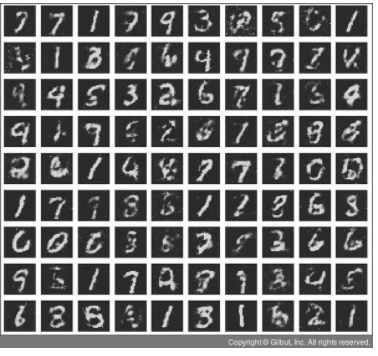

## 적대적 생성 신경망GAN (Generative adversarial network)

GAN이라는 신경망은 2개의 신경망으로 구성되어 있다.. 판별자 신경망과  생성자 신경망으로 나뉜다.  
생성자는 아무런 의미가 없는 그림에서 진짜처럼 그럴듯한 가짜 그림을 생성할 수 있으며, 판별자는 진짜 그림과 생성자가 만든 가짜 그림을 구별할 수 있다. 생성자는 판별자가 진짜처럼 생각하도록 만드는것이 목표이며, 판별자는 생성자가 진짜인지 가짜인지 다 구별하는것이 목표이다.
결론적으로 두 개의 신경망을 사용하여 새로운 그림을 생성해 내는 기법이 바로 적대적 생성 신경망이라 할 수 있다.


In [ ]:
from keras.models import Model, Sequential #신경망만들기위한 시퀀셜(Sequential) 모델
from keras.layers import Dense, Input #Dense와 Input 함수
from keras.layers.advanced_activations import LeakyReLU #액티베이션 함수
from tensorflow.keras.optimizers import Adam #옵티마이저 
from keras.datasets import mnist 
from tqdm import tqdm #시각라이브러리
import numpy as np
import matplotlib.pyplot as plt

## 데이터 불러오기

훈련 데이터(x_train)는 60,000개이며, 
x_test는 그중 10,000개로 학습을 시킬 예정이다.

In [ ]:
# mnist 훈련데이터셋
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = (x_test.astype(np.float32) - 127.5) / 127.5
mnist_data = x_test.reshape(10000, 784)
print(mnist_data.shape)
len(mnist_data)

11501568/11490434 [==============================] - 0s 0us/step
(10000, 784)


10000

훈련 데이터 x_train(이미지), y_train(레이블)  
검증 데이터 x_test(이미지), y_test(레이블)
그 데이터의 세부 값을 (–1)~(1) 사이의 값으로 나타내기 위해, 먼저 나눌 수 있는 실수 값으로 데이터를 변경합니다(x_test.astype(np.float32)).  
다음으로 데이터를 (–1)~(1) 사이의 값으로 변경합니다. mnist 데이터셋의 그림은 0~255까지의 숫자로 이루어져 있는데, 그 중간 값인 127.5를 뺀 후 다시 127.5로 나누면((x_test.astype(np.float32) - 127.5)/127.5) 0은 -1로, 255는 1로 값이 바뀌며, 그 중간 값 또한 비율에 따라 축소됩니다. 그리고 이렇게 변경된 값을 x_test로 저장합니다.

## 생성자 신경망 만들기  
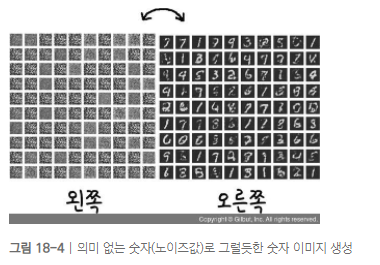



아래에서는 손글씨를 생성하는 생성자 신경망을 구성한다. 신경망에 아무런 의미 없는숫자(노이즈)를 집어넣어 새로운 숫자들을 생성한다.

In [ ]:
def create_generator():
    generator = Sequential() # 인공지능 모델 생성
    generator.add(Dense(units=256,input_dim=100)) # 신경망 첫번쨰층 노이즈값 100
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=512)) # 신경망 두번째 층
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=784, activation='tanh')) # 1×784 픽셀로. 추후 28×28로 변환
    return generator
g = create_generator()
# 출력
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 559,632
Trainable params: 559,632
Non-trainable params: 0
_________________________________________________________________


##판별자 신경망 만들기
생성자 신경망이 만든 이미지가 가짜인지를 정확하게 판별하는 신경망


In [ ]:
def create_discriminator():
    discriminator = Sequential()  # 판별자 인공지능 모델 생성
    discriminator.add(Dense(units=512,input_dim=784)) # input = 생성자가 생성한 손글씨(784개 픽셀)
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=1, activation='sigmoid')) # 진짜면 1을, 가짜면 0
    discriminator.compile(loss='binary_crossentropy', # 오차 값(loss)은 이항 교차 엔트로피(binary_crossentropy)
optimizer = Adam(lr=0.0002, beta_1=0.5)) # 아담(Momentum + AdaGrad) 학습률을 줄여나가고 속도를 계산하여 학습의 갱신강도를 적응적으로 조정해나가는 방법

    return discriminator
d = create_discriminator()
# 출력
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## GAN 생성 함수 만들기


적대적 생성 신경망을 구성

In [ ]:
def create_gan(discriminator, generator): # 인자로 판별자와 생성자
    discriminator.trainable=False # 판별자가 학습을 하지 못하도록 막기
    gan_input = Input(shape=(100,)) # 적대적 생성 신경망인 gan에 입력할 데이터의 모습을 정하는 코드 ,값 뒤를 비워두면 자동적으로 전체개수 10,000개가 들어감
    x = generator(gan_input)
    gan_output = discriminator(x) # 결괏값 데이터는 바로 판별자가 생성자가 만든 그림(x)을 보고 판단한 결과
    gan = Model(inputs=gan_input, outputs=gan_output) # 적대적 생성 신경망 gan 모델 // 입력값 inputs=gan_input는 신경망이 만든 그림 , 출력값(outputs=gan_output)은 판별자 신경망이 판단한 결과
    gan.compile(loss='binary_crossentropy', optimizer='adam') # 오차손실함수, 출력값 = binary 맞는지 틀린지
    return gan
gan = create_gan(d,g) # 판별자 신경망인 d와 생성자 신경망인 g
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               559632    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 1,093,137
Trainable params: 559,632
Non-trainable params: 533,505
_________________________________________________________________


## 결과 확인 함수 만들기
신경망으로 그림을 그리고 사람이 직접 확인하는 방법

In [ ]:
def plot_generated_images(generator):
    noise = np.random.normal(loc=0, scale=1, size=[100, 100]) # 정규 분포 함수로 균일한 노이즈값 생성 (평균=0, 평균에서=1만큼, 100종류,100개)
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=(10, 10)) # 그림사이즈
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i+1) # 그림위치 (가로,세로,방식)
        plt.imshow(generated_images[i], interpolation='nearest') # 
        plt.axis('off') #그림이름없음
    plt.tight_layout() # 띄우기

##적대적 생성 신경망 학습(훈련)시키기


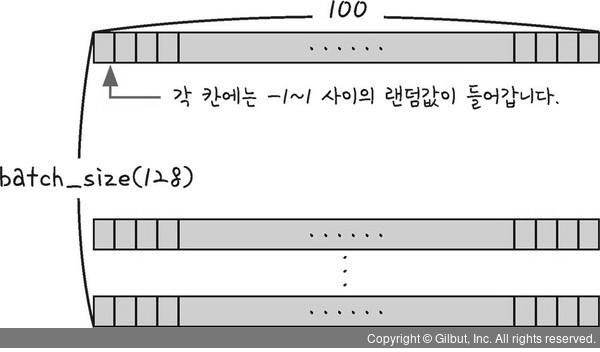

100%|██████████| 5000/5000 [04:37<00:00, 18.03it/s]


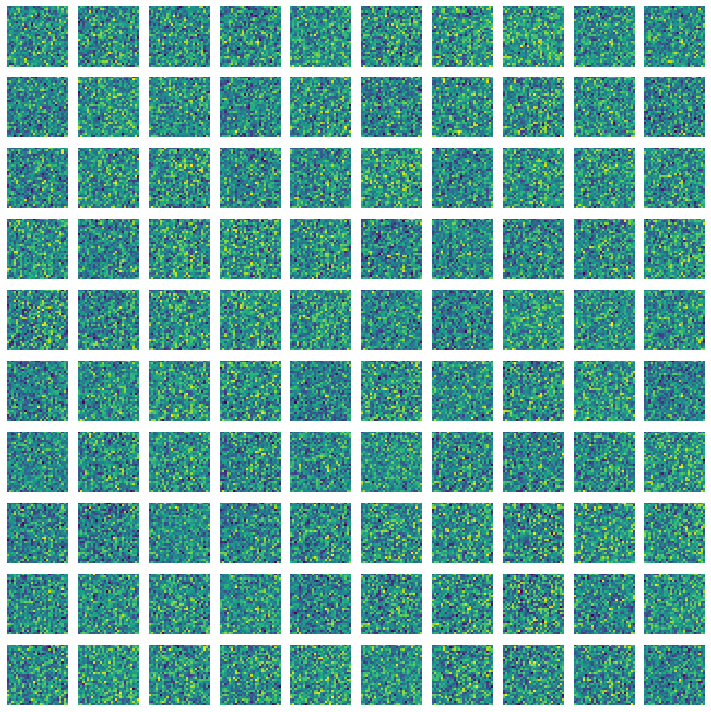

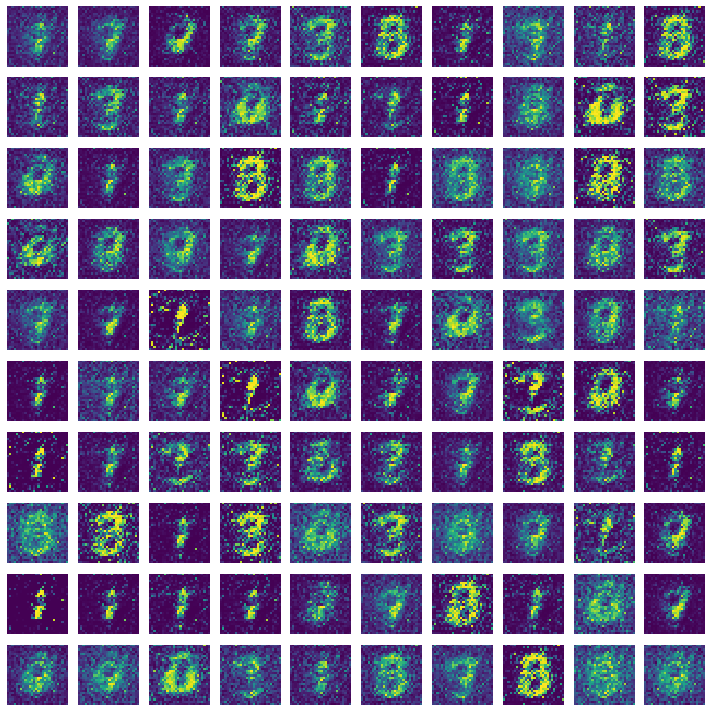

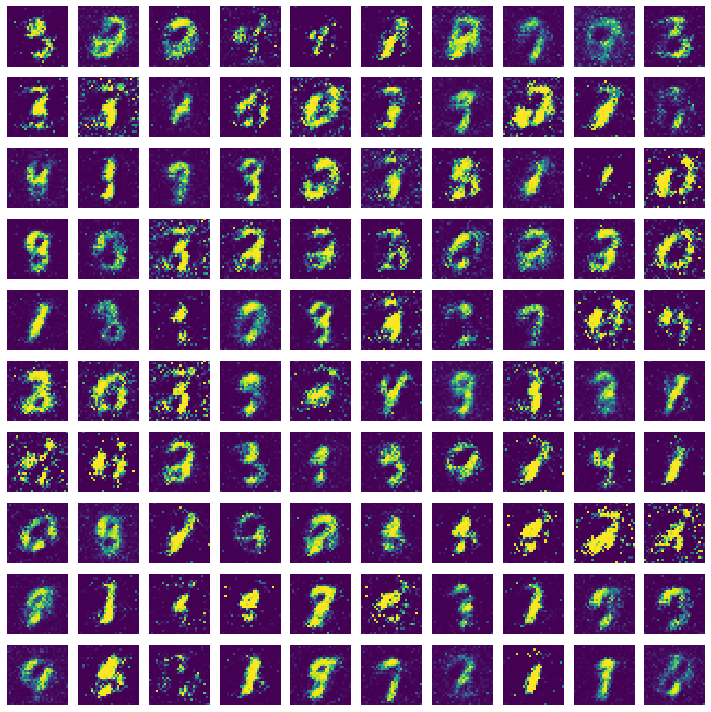

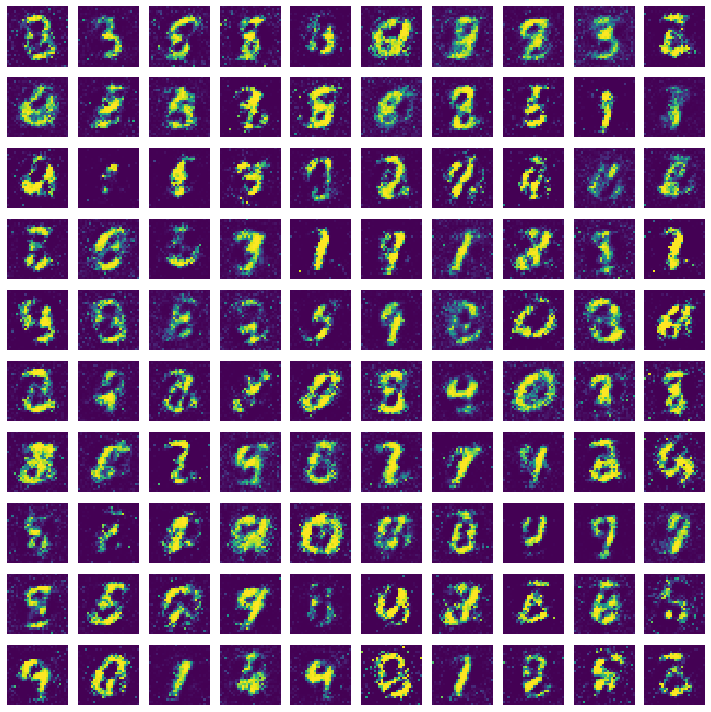

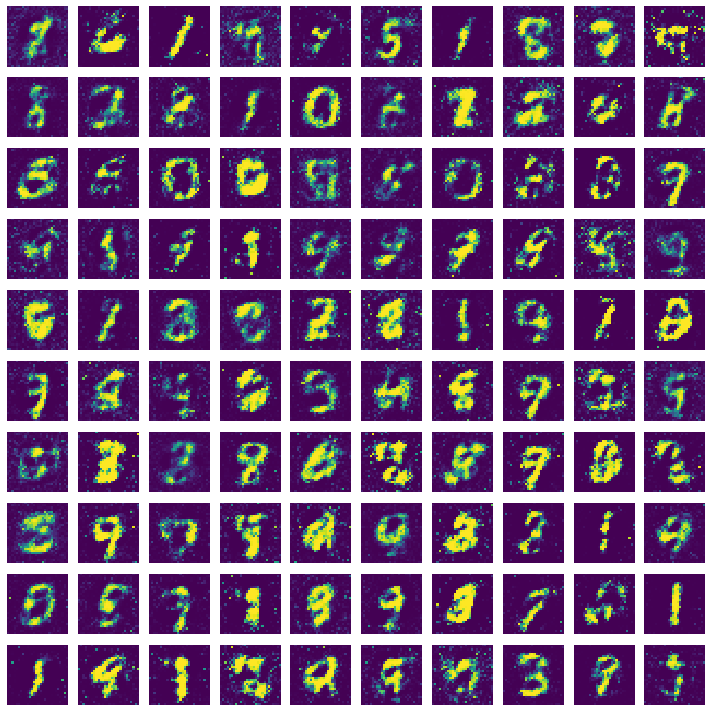

In [ ]:
batch_size = 128 # 한 번에 몇 개의 그림을 학습시킬지
epochs = 5000 # 반복횟수
for e in tqdm(range(epochs)):
    noise = np.random.normal(0,1, [batch_size, 100])  # 정규 분포 함수로 균일한 노이즈값 생성 (평균=0, 평균에서=1만큼, 배치사이즈개수,100개)
    generated_images = g.predict(noise) # 생성자신경망 그림그리기
    image_batch = mnist_data[np.random.randint(low=0,
                  high=mnist_data.shape[0],size=batch_size)] # mnist 데이터셋(10,000개)에서 128개만 랜덤으로 뽑기
    X = np.concatenate([image_batch, generated_images]) # 진짜 그림과 생성한 그림을 합치는 모습
    ## 진짜 그림을 1으로, 가짜 그림을 0으로 표현
    # 128개는 진짜그림이란걸 알게하기위해 1 
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 1 
    d.trainable = True # 학습하도록
    d.train_on_batch(X, y_dis) # 판별자 학습
    noise = np.random.normal(0,1, [batch_size, 100]) # 노이즈값생성
    y_gen = np.ones(batch_size) # 판별자가 생성자가 만든그림을 진짜라고 오해하도록 1을 넣음
    d.trainable = False # 학습말고 판별만하도록
    gan.train_on_batch(noise, y_gen) # 출력값으로 모두 다 진짜(y_gen의 값은 1인 상태)
    if e == 0 or e % 1000 == 0:
       plot_generated_images(g) # 에포크(e == 1)와 1000, 2000, 3000, 4000, 5000번째 각 에포크(e % 1000 == 0)일 때 생성자가 만든 그림을 출력

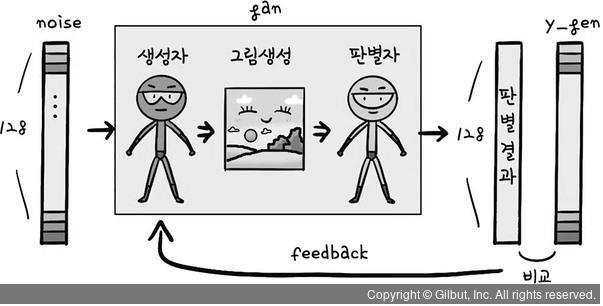

In [ ]:
#discriminator.trainable = False   # 판별자를 더 이상 학습시키지 않습니다.
#gan_input = Input(shape=(100,))
#x = generator(gan_input)          # 노이즈값을 넣어서 새로운 그림을 생성한 후 x에 넣습니다.
#gan_output = discriminator(x)     # 판별자가 x를 판별하도록 합니다.